<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2274/2274 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.8958 - loss: 0.2605 - val_accuracy: 0.9688 - val_loss: 0.0723 - learning_rate: 5.0000e-04
Epoch 2/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9598 - loss: 0.0857 - val_accuracy: 0.9678 - val_loss: 0.0664 - learning_rate: 5.0000e-04
Epoch 3/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9655 - loss: 0.0759 - val_accuracy: 0.9691 - val_loss: 0.0556 - learning_rate: 5.0000e-04
Epoch 4/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9681 - loss: 0.0680 - val_accuracy: 0.9712 - val_loss: 0.0508 - learning_rate: 5.0000e-04
Epoch 5/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9702 - loss: 0.0614 - val_accuracy: 0.9758 - val_loss: 0.0492 - learning_rate: 5.0000e-04
Epoch 6/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9724 - loss: 0.0585 - val_accuracy: 0.9775 - val_loss: 0.0458 - learning_rate: 5.0000e-04
Epoch 7/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/

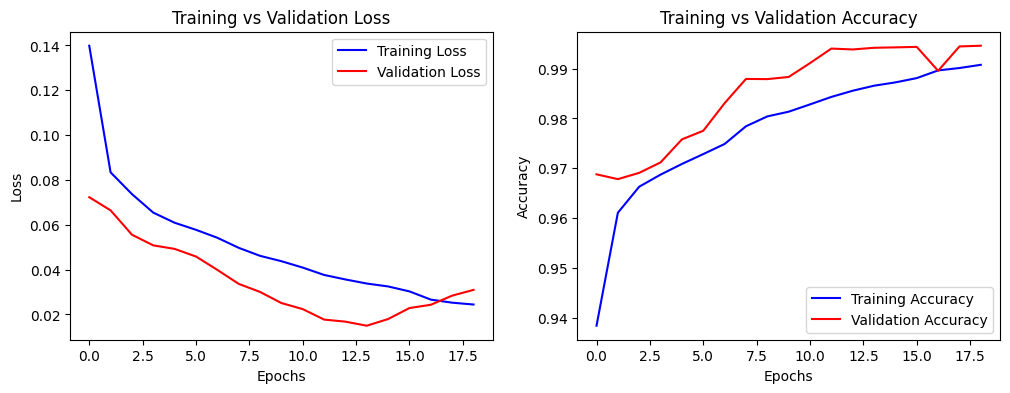

4548/4548 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


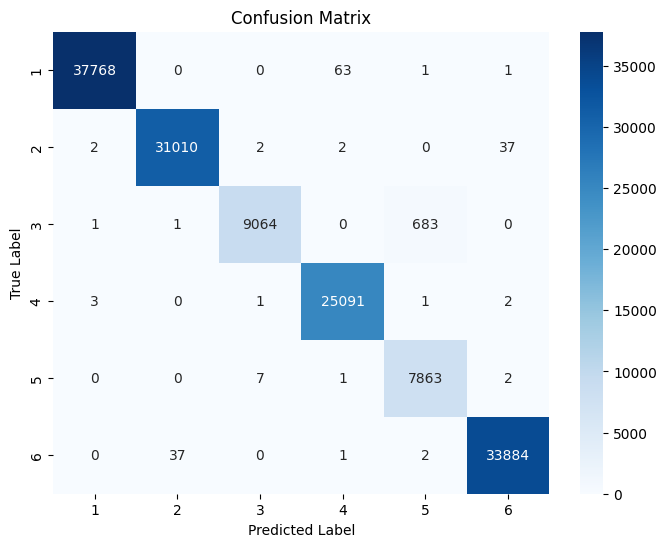


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37833
           2       1.00      1.00      1.00     31053
           3       1.00      0.93      0.96      9749
           4       1.00      1.00      1.00     25098
           5       0.92      1.00      0.96      7873
           6       1.00      1.00      1.00     33924

    accuracy                           0.99    145530
   macro avg       0.99      0.99      0.99    145530
weighted avg       0.99      0.99      0.99    145530



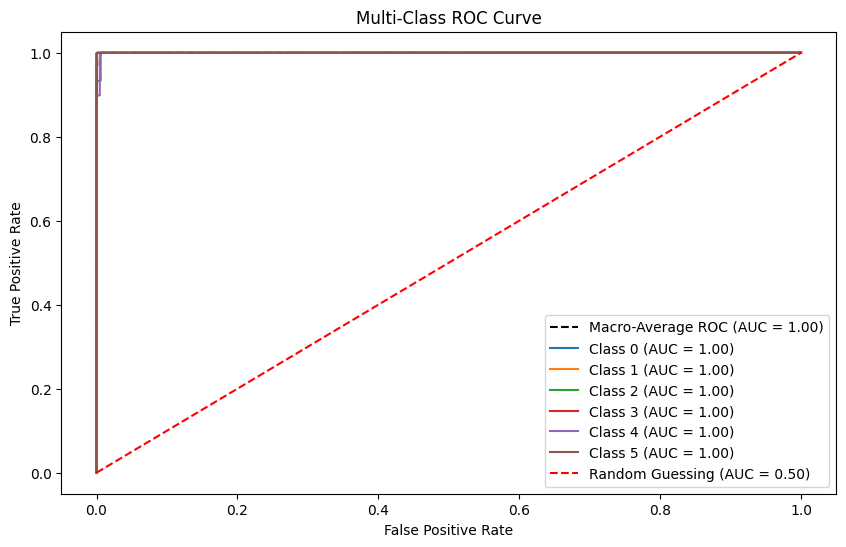

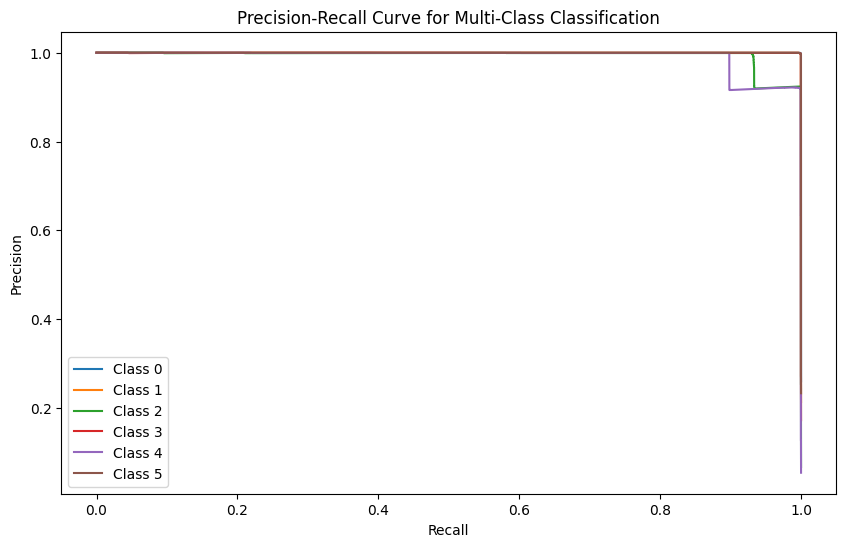

ValueError: could not convert string to float: 'Batticaloa'

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
df = pd.read_csv('Cleaned_train.csv')  # Replace with actual dataset path

# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_catgeory']

# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Add Gaussian noise to training data for better generalization
noise_factor = 0.01  # Small noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Increased dropout

    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)  # Reduced patience

# Train the model
history = model.fit(X_train_noisy, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Check for Overfitting/Underfitting
plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))

# Multi-Class ROC Curve
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Macro-Average ROC Curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average ROC (AUC = {roc_auc["macro"]:.2f})', color='black', linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.legend()
plt.show()

# Predict Cluster Categories for Cleaned Test Dataset
cleaned_test = pd.read_csv('cleaned_test.csv')  # Load your test dataset
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

# Standardize using the same scaler
X_cleaned_test_scaled = scaler.transform(X_cleaned_test)

# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test_scaled)
cleaned_test['Predicted_Cluster_Category'] = label_encoder.inverse_transform(np.argmax(cleaned_test_predictions, axis=1))

# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# ---- Step 1: Load Data ----
# Assuming you have a CSV file, adjust the path accordingly
df = pd.read_csv("your_dataset.csv")

# ---- Step 2: Handle Categorical Data ----
# Convert non-numeric columns to numeric using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for inverse transformation later if needed

# ---- Step 3: Split Features and Target ----
X = df.drop(columns=['target'])  # Replace 'target' with your actual target column
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Step 4: Scale Data ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Step 5: Build Neural Network Model ----
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Dropout to reduce overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(len(y.unique()), activation='softmax')  # Adjust output neurons based on number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---- Step 6: Train Model with Early Stopping ----
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=50, batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping])

# ---- Step 7: Plot Training & Validation Loss and Accuracy ----
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# ---- Step 8: Evaluate Model ----
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---- Step 9: Generate Confusion Matrix ----
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ---- Step 1: Load Data ----
df = pd.read_csv("Cleaned_train.csv")

# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_catgeory']

# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Add Gaussian noise to training data for better generalization
noise_factor = 0.01  # Small noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Step 4: Scale Data ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Step 5: Build Neural Network Model ----
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(len(np.unique(y)), activation='softmax')  # Softmax for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---- Step 6: Train Model with Early Stopping ----
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    epochs=50, batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping])

# ---- Step 7: Save and Load the Model ----
model.save("trained_model.h5")
del model
model = load_model("trained_model.h5")

# ---- Step 8: Plot Training & Validation Loss and Accuracy ----
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# ---- Step 9: Evaluate Model ----
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---- Step 10: Generate Confusion Matrix ----
y_pred_prob = model.predict(X_test_scaled)  # Get probability predictions
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ---- Step 11: Classification Report ----
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ---- Step 12: Multi-Class ROC Curve ----
y_test_bin = label_binarize(y_test, classes=np.arange(len(np.unique(y))))  # Binarize labels
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Macro-Average ROC Curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average ROC (AUC = {roc_auc["macro"]:.2f})', color='black', linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()

# ---- Step 13: Precision-Recall Curve ----
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multi-Class Classification")
plt.legend()
plt.show()

# ---- Step 14: Predict Cluster Categories for Cleaned Test Dataset ----
cleaned_test = pd.read_csv('cleaned_test.csv')

# Ensure the columns match training data
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

# Standardize using the same scaler
X_cleaned_test_scaled = scaler.transform(X_cleaned_test)

# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test_scaled)
cleaned_test['Predicted_Cluster_Category'] = label_encoders['target'].inverse_transform(np.argmax(cleaned_test_predictions, axis=1))

# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")

KeyError: "['target'] not found in axis"

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2274/2274 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.8963 - loss: 0.2572 - val_accuracy: 0.9601 - val_loss: 0.0747 - learning_rate: 5.0000e-04
Epoch 2/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9584 - loss: 0.0876 - val_accuracy: 0.9670 - val_loss: 0.0720 - learning_rate: 5.0000e-04
Epoch 3/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.9653 - loss: 0.0785 - val_accuracy: 0.9723 - val_loss: 0.0632 - learning_rate: 5.0000e-04
Epoch 4/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9676 - loss: 0.0708 - val_accuracy: 0.9729 - val_loss: 0.0536 - learning_rate: 5.0000e-04
Epoch 5/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9697 - loss: 0.0633 - val_accuracy: 0.9736 - val_loss: 0.0498 - learning_rate: 5.0000e-04
Epoch 6/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9718 - loss: 0.0597 - val_accuracy: 0.9776 - val_loss: 0.0452 - learning_rate: 5.0000e-04
Epoch 7/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/

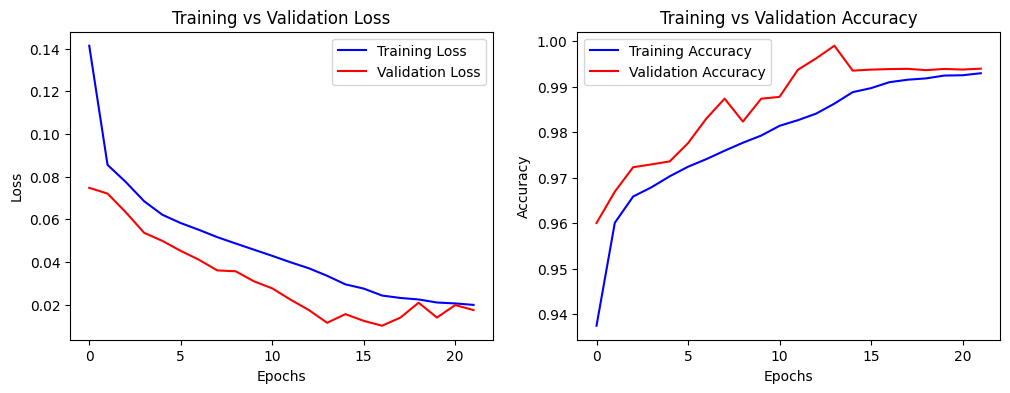

4548/4548 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


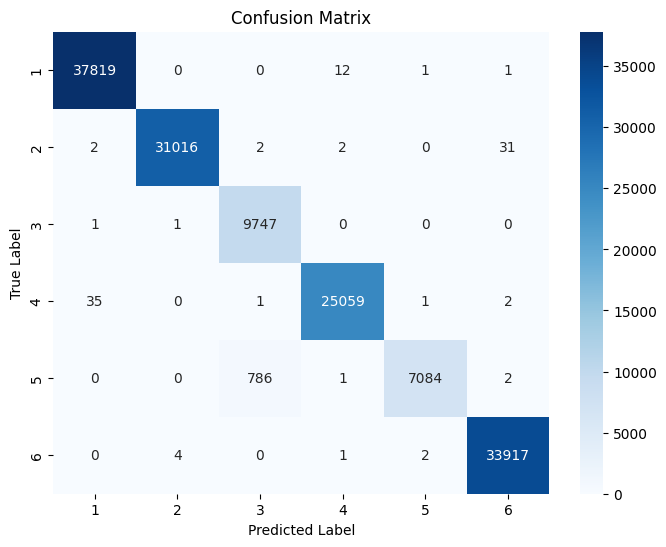


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37833
           2       1.00      1.00      1.00     31053
           3       0.93      1.00      0.96      9749
           4       1.00      1.00      1.00     25098
           5       1.00      0.90      0.95      7873
           6       1.00      1.00      1.00     33924

    accuracy                           0.99    145530
   macro avg       0.99      0.98      0.98    145530
weighted avg       0.99      0.99      0.99    145530



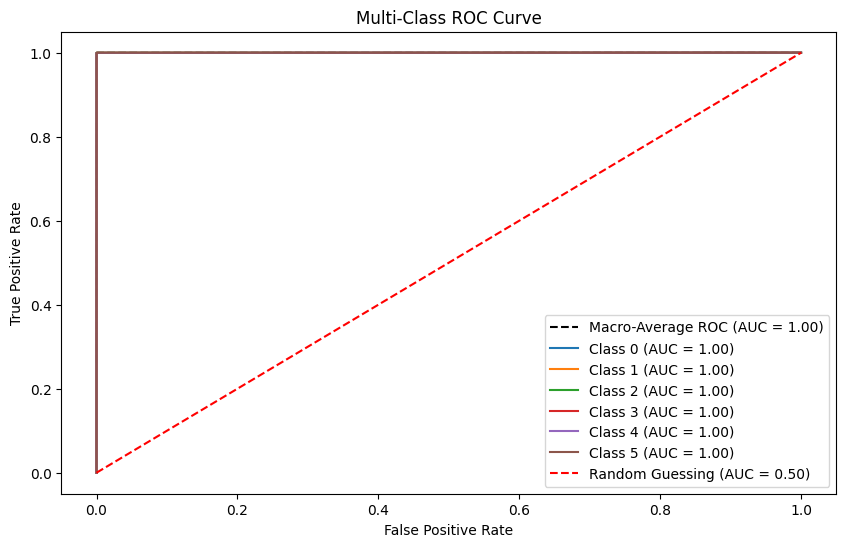

ValueError: invalid literal for int() with base 10: 'Batticaloa'

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
df = pd.read_csv('Cleaned_train.csv')  # Replace with actual dataset path

# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_catgeory']

# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Add Gaussian noise to training data for better generalization
noise_factor = 0.01  # Small noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Increased dropout

    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)  # Reduced patience

# Train the model
history = model.fit(X_train_noisy, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Check for Overfitting/Underfitting
plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))

# Multi-Class ROC Curve
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Macro-Average ROC Curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average ROC (AUC = {roc_auc["macro"]:.2f})', color='black', linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()

In [35]:
# Load cleaned test dataset
cleaned_test = pd.read_csv('cleaned_test.csv')

# Ensure 'outlet_city' is a string type
if 'outlet_city' in cleaned_test.columns:
    cleaned_test['outlet_city'] = cleaned_test['outlet_city'].astype(str)  # Convert to string if needed

# Apply the same encoding as in training
if 'outlet_city' in df.columns:  # Ensure training data had 'outlet_city'
    outlet_city_encoder = LabelEncoder()
    outlet_city_encoder.fit(df['outlet_city'])  # Fit on training data

    # Create a mapping dictionary from training cities
    outlet_city_mapping = dict(zip(outlet_city_encoder.classes_, outlet_city_encoder.transform(outlet_city_encoder.classes_)))

    # Encode outlet_city safely: Map known cities, assign -1 to unknowns
    cleaned_test['outlet_city'] = cleaned_test['outlet_city'].map(outlet_city_mapping).fillna(-1).astype(int)

# Select the same features used in training
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

# Standardize using the same scaler
X_cleaned_test_scaled = scaler.transform(X_cleaned_test)

# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test_scaled)
cleaned_test['Predicted_Cluster_Category'] = label_encoder.inverse_transform(np.argmax(cleaned_test_predictions, axis=1))

# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")


1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Predictions saved successfully!
